In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv('./data/lol/high_diamond_ranked_10min.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

### 数据分析

共有9879条数据, 并没有缺失数据, 并且变量类型全是数值型变量, 包括连续型数值变量以及离散型数值变量.

蓝红方的胜率基本55开, 前两行是gameid, 和蓝色方是否胜利.

后面还有38个特征, 每队有19个特征, 特征类型是一样的.

- blueWardsPlaced, blueWardsDestroyed, 插眼和反眼

- blueFirstBlood 蓝色方是否拿了一血

- blueKills, blueDeaths, blueAssists 蓝色方的击杀, 死亡, 助攻, 能换算为KDA

- blueEliteMonsters, blueDragons, blueHeralds 蓝色方精英怪, 小龙, 先锋击杀数

- blueTowersDestroyed 蓝色方推塔数

- blueTotalGold 蓝色方经济

- blueAvgLevel 蓝色方平均等级

- blueTotalMinionsKilled 蓝色方击杀小兵数

- blueTotalJungleMinionsKilled 蓝色方野区野怪击杀数

- blueGoldDiff, blueExperienceDiff, blueCSPerMin, blueGoldPerMin 经济差, 经验差, 分均补刀, 分均经济

根据以上数据, 我从以下几个方向对游戏走向进行分析:

- **视野**

- **一血率**

- **KDA战损比**

- **重要资源掌控以及野区对位情况**

- **对线情况**

- **双方经济以及经验数据分析**

- **双方经验差**

#### 视野数据的分析

In [133]:
print('mean :', round(data['blueWardsPlaced'].mean(),2))
print('min :', data['blueWardsPlaced'].min())
print('max :', data['blueWardsPlaced'].max())

mean : 22.29
min : 5
max : 250


竟然有一局游戏, 蓝色方10分钟插了250个眼, 不太科学...

数据中应该有离群点, 我们试着找一下

In [8]:
len(data[(data.blueWardsPlaced>=50) | (data.redWardsPlaced >= 50)])

1142

有1142个对局前10分钟, 有一方插到了50个眼, 显然这个数据不太正确. 

因此对于视野数据, 我们先把这些离群点给剔除, 再进行分析.

In [10]:
drop_index = data[(data.blueWardsPlaced>=50) | (data.redWardsPlaced >= 50)].index

In [11]:
data_v1 = data.drop(index = drop_index)

求出双方的插眼情况的比值

In [12]:
data_v1['divWardsPlaced'] = (data_v1['blueWardsPlaced'] + 1) / (data_v1['redWardsPlaced'] + 1)

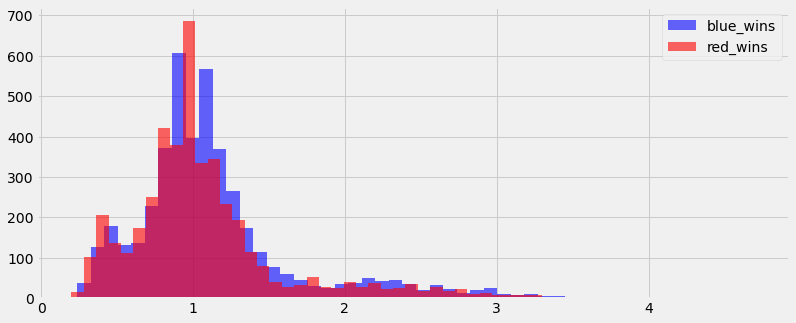

In [13]:
plt.figure(figsize=(12,5))
data_v1[data_v1.blueWins == 1]['divWardsPlaced'].hist(bins = 50, color = 'blue', label = 'blue_wins', alpha=0.6)
data_v1[data_v1.blueWins == 0]['divWardsPlaced'].hist(bins = 50, color = 'red', label = 'red_wins', alpha=0.6)
plt.legend()
plt.show()

根据红蓝双方的插眼反眼数, 构造一个新的变量出来.

视野压制 = (蓝色方插眼数 - 红色方反眼数 + 1) / (红色方插眼数 - 蓝色方反眼数 + 1)

In [31]:
data_v1['VisionSuppression'] = (data_v1['blueWardsPlaced'] - data_v1['redWardsPlaced'] ) - ( data_v1['redWardsPlaced'] - data_v1['blueWardsDestroyed'])

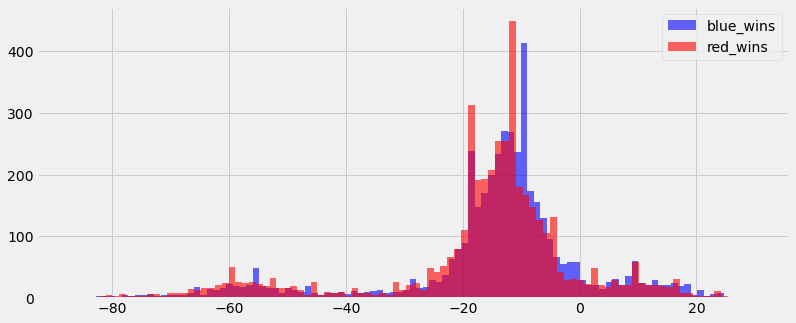

In [32]:
plt.figure(figsize=(12,5))
data_v1[data_v1.blueWins == 1]['VisionSuppression'].hist(bins = 100, color = 'blue', label = 'blue_wins', alpha=0.6)
data_v1[data_v1.blueWins == 0]['VisionSuppression'].hist(bins = 100, color = 'red', label = 'red_wins', alpha=0.6)
plt.legend()
plt.show()

暂时看不出和胜负有很大的关联性, 那么这个数据就暂时放一边吧

#### 一血率与获胜的关系

In [17]:
data.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


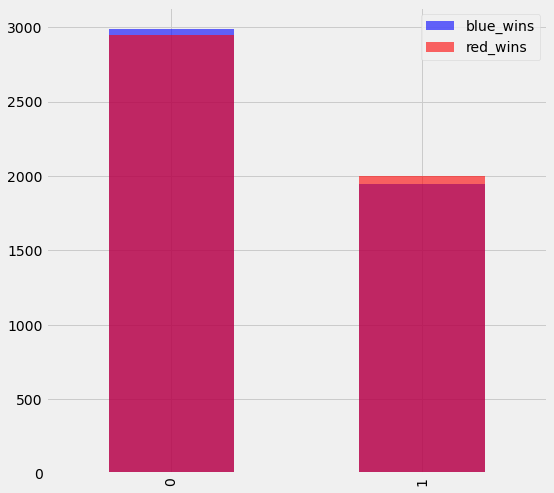

In [19]:
plt.figure(figsize = (8,8))
data[data.blueWins == 1]['blueFirstBlood'].value_counts().plot(kind='bar', color = 'blue', label = 'blue_wins', alpha = 0.6)
data[data.blueWins == 0]['blueFirstBlood'].value_counts().plot(kind='bar', color = 'red', label = 'red_wins', alpha = 0.6)
plt.legend()

蓝色方不拿一血的胜率竟然比拿一血的胜率要高.

#### KDA对获胜的影响

In [20]:
data['blueKDA'] = (data['blueKills'] + data['blueAssists']) / (data['blueDeaths'] + 1)
data['redKDA'] = (data['redKills'] + data['redAssists']) / (data['redDeaths'] + 1)

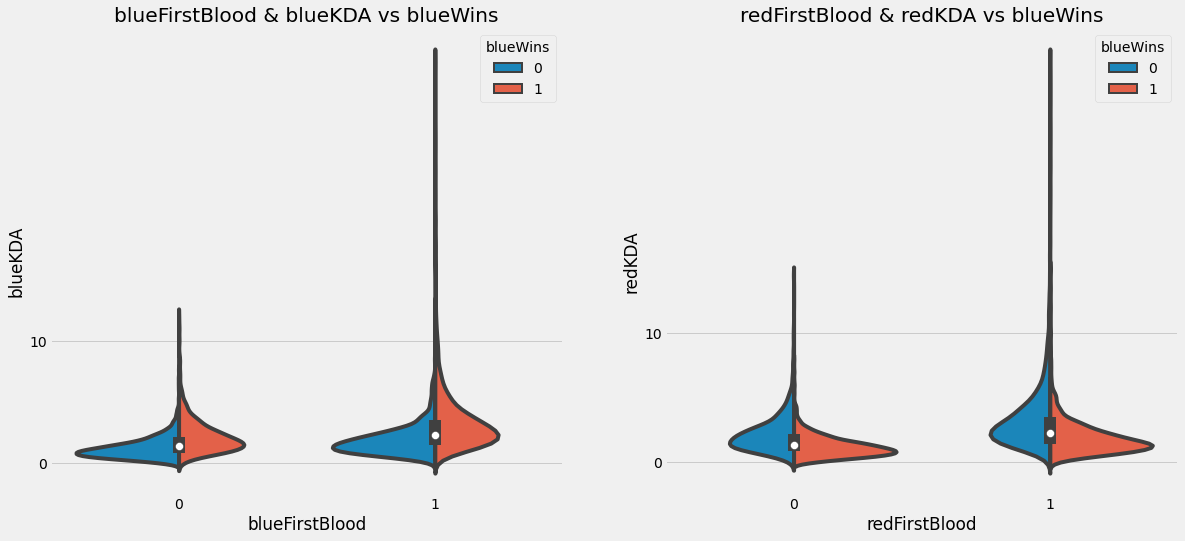

In [21]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("blueFirstBlood","blueKDA", hue="blueWins", data=data,split=True,ax=ax[0])
ax[0].set_title('blueFirstBlood & blueKDA vs blueWins')
ax[0].set_yticks(range(0,20,10))
sns.violinplot("redFirstBlood","redKDA", hue="blueWins", data=data,split=True,ax=ax[1])
ax[1].set_title('redFirstBlood & redKDA vs blueWins')
ax[1].set_yticks(range(0,20,10))
plt.show()

可以看到的是, 不管前期有没有拿一血, 获胜方的前10分钟,队伍KDA都比较高

#### 野区的情况

首先查看重要资源掌控情况与获胜的关系.

先查看这三个特征的分布情况

blueEliteMonsters, blueDragons, blueHeralds

查看这三个变量与获胜之间的关系.

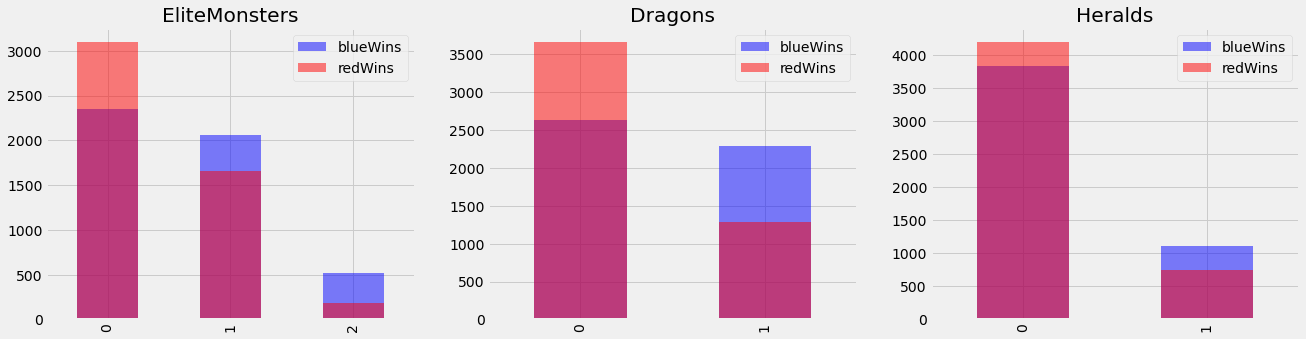

In [23]:
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
data[data.blueWins == 1]['blueEliteMonsters'].value_counts().plot(kind = 'bar', color = 'blue',label = 'blueWins', alpha = 0.5)
data[data.blueWins == 0]['blueEliteMonsters'].value_counts().plot(kind = 'bar', color = 'red',label = 'redWins', alpha = 0.5)
plt.legend()
plt.title('EliteMonsters')
plt.subplot(1,3,2)
data[data.blueWins == 1]['blueDragons'].value_counts().plot(kind = 'bar', color = 'blue',label = 'blueWins', alpha = 0.5)
data[data.blueWins == 0]['blueDragons'].value_counts().plot(kind = 'bar', color = 'red',label = 'redWins', alpha = 0.5)
plt.legend()
plt.title('Dragons')
plt.subplot(1,3,3)
data[data.blueWins == 1]['blueHeralds'].value_counts().plot(kind = 'bar', color = 'blue',label = 'blueWins', alpha = 0.5)
data[data.blueWins == 0]['blueHeralds'].value_counts().plot(kind = 'bar', color = 'red',label = 'redWins', alpha = 0.5)
plt.title('Heralds')
plt.legend()
plt.show()

将这三个变量与红色方的对应3个变量作差

In [24]:
data['diffEliteMonsters'] = data['blueEliteMonsters'] - data['redEliteMonsters']
data['diffDragons'] = data['blueDragons'] - data['redDragons']
data['diffHearlds'] = data['blueHeralds'] - data['redHeralds']

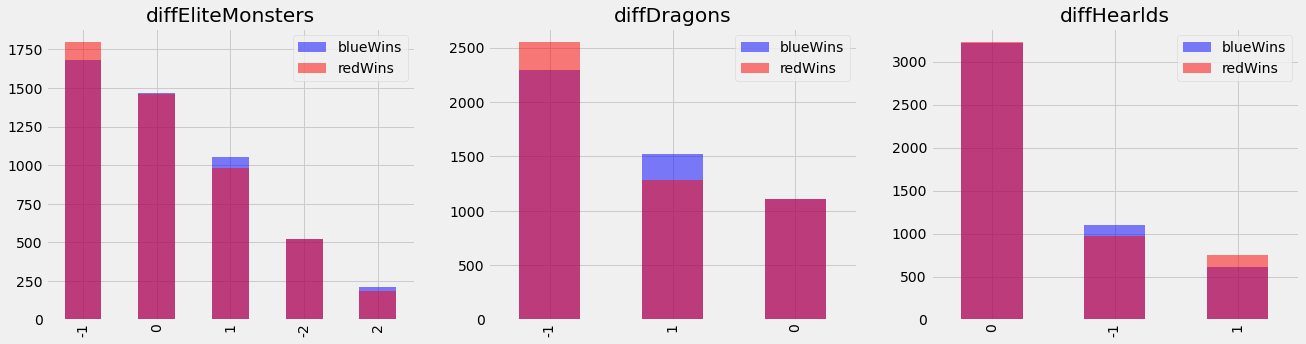

In [25]:
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
data[data.blueWins == 1]['diffEliteMonsters'].value_counts().plot(kind = 'bar', color = 'blue',label = 'blueWins', alpha = 0.5)
data[data.blueWins == 0]['diffEliteMonsters'].value_counts().plot(kind = 'bar', color = 'red',label = 'redWins', alpha = 0.5)
plt.legend()
plt.title('diffEliteMonsters')
plt.subplot(1,3,2)
data[data.blueWins == 1]['diffDragons'].value_counts().plot(kind = 'bar', color = 'blue',label = 'blueWins', alpha = 0.5)
data[data.blueWins == 0]['diffDragons'].value_counts().plot(kind = 'bar', color = 'red',label = 'redWins', alpha = 0.5)
plt.legend()
plt.title('diffDragons')
plt.subplot(1,3,3)
data[data.blueWins == 1]['diffHearlds'].value_counts().plot(kind = 'bar', color = 'blue',label = 'blueWins', alpha = 0.5)
data[data.blueWins == 0]['diffHearlds'].value_counts().plot(kind = 'bar', color = 'red',label = 'redWins', alpha = 0.5)
plt.title('diffHearlds')
plt.legend()
plt.show()

野区对位情况

blueTotalJungleMinionsKilled

redTotalJungleMinionsKilled

我们将两个变量相减得到

diffTotalJungleMinionsKilled

In [33]:
data['diffTotalJungleMinionsKilled'] = (data['blueTotalJungleMinionsKilled']) - (data['redTotalJungleMinionsKilled'])

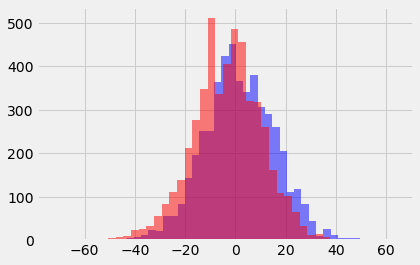

In [34]:
data[data.blueWins == 1]['diffTotalJungleMinionsKilled'].hist(bins=40, color='blue', label = 'blueWins', alpha=0.5)
data[data.blueWins == 0]['diffTotalJungleMinionsKilled'].hist(bins=40, color='red', label = 'redWins', alpha=0.5)

可以看到的是, 野区优势对获胜也有一定的影响

#### 对线对获胜的影响

红蓝双方推塔数以及双方的补刀差

首先看双方的补刀差

In [35]:
data['diffTotalMinionsKilled'] = data['blueTotalMinionsKilled'] - data['redTotalMinionsKilled']

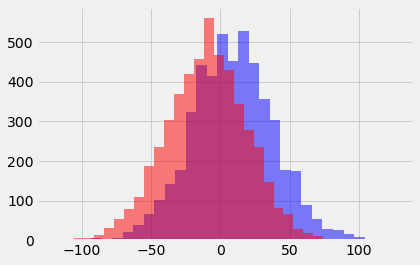

In [36]:
data[data.blueWins == 1]['diffTotalMinionsKilled'].hist(bins=30, color='blue', label = 'blueWins', alpha=0.5)
data[data.blueWins == 0]['diffTotalMinionsKilled'].hist(bins=30, color='red', label = 'redWins', alpha=0.5)

红蓝双方推塔数对获胜的影响

Text(0.5, 1.0, 'Red_Tower')

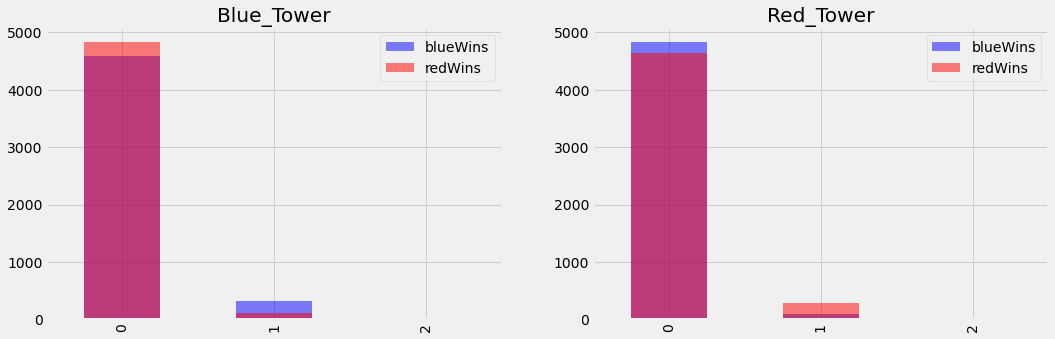

In [37]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
data[data.blueWins == 1]['blueTowersDestroyed'].value_counts().plot(kind = 'bar', color = 'blue',label = 'blueWins', alpha = 0.5)
data[data.blueWins == 0]['blueTowersDestroyed'].value_counts().plot(kind = 'bar', color = 'red',label = 'redWins', alpha = 0.5)
plt.legend()
plt.title('Blue_Tower')
plt.subplot(1,2,2)
data[data.blueWins == 1]['redTowersDestroyed'].value_counts().plot(kind = 'bar', color = 'blue',label = 'blueWins', alpha = 0.5)
data[data.blueWins == 0]['redTowersDestroyed'].value_counts().plot(kind = 'bar', color = 'red',label = 'redWins', alpha = 0.5)
plt.legend()
plt.title('Red_Tower')

In [38]:
data['diffTowersDestroyed'] = data['blueTowersDestroyed'] - data['redTowersDestroyed']

Text(0.5, 1.0, 'diffTower')

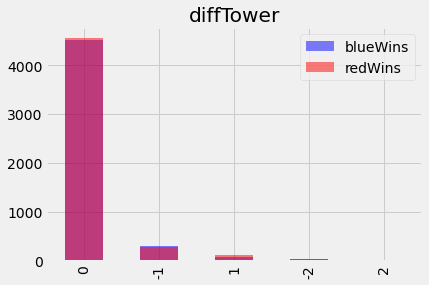

In [39]:
data[data.blueWins == 1]['diffTowersDestroyed'].value_counts().plot(kind = 'bar', color = 'blue',label = 'blueWins', alpha = 0.5)
data[data.blueWins == 0]['diffTowersDestroyed'].value_counts().plot(kind = 'bar', color = 'red',label = 'redWins', alpha = 0.5)
plt.legend()
plt.title('diffTower')

在前10分钟是否推掉对面防御塔是十分关键的.

#### 经济以及经验对获胜的影响

查看经济差以及经验差

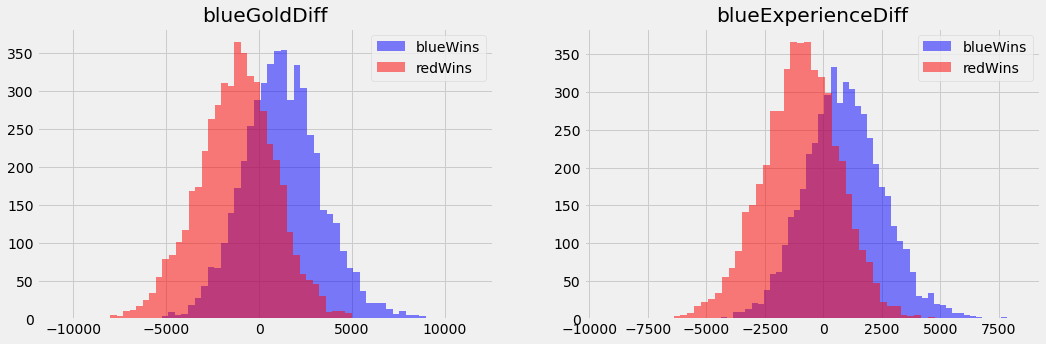

In [41]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
data[data.blueWins == 1]['blueGoldDiff'].hist(bins = 50, color = 'blue',label = 'blueWins', alpha = 0.5)
data[data.blueWins == 0]['blueGoldDiff'].hist(bins = 50, color = 'red',label = 'redWins', alpha = 0.5)
plt.legend()
plt.title('blueGoldDiff')
plt.subplot(1,2,2)
data[data.blueWins == 1]['blueExperienceDiff'].hist(bins = 50, color = 'blue',label = 'blueWins', alpha = 0.5)
data[data.blueWins == 0]['blueExperienceDiff'].hist(bins = 50, color = 'red',label = 'redWins', alpha = 0.5)
plt.legend()
plt.title('blueExperienceDiff')
plt.show()

#### 组合成最后的数据集

保留 : gameId, blueWins, blueFirstBlood, redFirstBlood, blueKDA, redKDA, diffEliteMonsters, diffDragons, diffHeralds
, diffTowersDestroyed, blueGoldDiff, blueExperienceDiff, diffTotalJungleMinionsKilled, diffTotalMinionsKilled

In [42]:
data.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueKDA,redKDA,diffEliteMonsters,diffDragons,diffHearlds,divTotalJungleMinionsKilled,diffTotalJungleMinionsKilled,diffTotalMinionsKilled,diffTowersDestroyed
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7,2.857143,1.400000,0,0,0,0.660714,-19,-2,0
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0,1.666667,1.166667,-2,-1,-1,0.830189,-9,-66,-1
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5,0.916667,3.125000,1,1,0,1.620690,18,-17,0
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8,1.500000,3.000000,1,0,1,1.166667,8,-34,0
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4,1.714286,1.857143,-1,-1,0,0.852941,-10,-15,0


In [43]:
choose_cols = ['blueWins', 'blueFirstBlood', 'redFirstBlood', 'blueKDA', 'redKDA', 
               'diffEliteMonsters', 'diffDragons', 'diffHearlds', 'diffTowersDestroyed',
               'blueGoldDiff', 'blueExperienceDiff',
               'diffTotalJungleMinionsKilled', 'diffTotalMinionsKilled',
              ]
data_final = data[choose_cols].copy(deep = True)

In [44]:
data_final.head()

,blueWins,blueFirstBlood,redFirstBlood,blueKDA,redKDA,diffEliteMonsters,diffDragons,diffHearlds,diffTowersDestroyed,blueGoldDiff,blueExperienceDiff,diffTotalJungleMinionsKilled,diffTotalMinionsKilled
0,0,1,0,2.857143,1.400000,0,0,0,0,643,-8,-19,-2
1,0,0,1,1.666667,1.166667,-2,-1,-1,-1,-2908,-1173,-9,-66
2,0,0,1,0.916667,3.125000,1,1,0,0,-1172,-1033,18,-17
3,0,0,1,1.500000,3.000000,1,0,1,0,-1321,-7,8,-34
4,0,0,1,1.714286,1.857143,-1,-1,0,0,-1004,230,-10,-15


#### 变量之间的相关性

In [45]:
corr_matrix = data_final.corr()

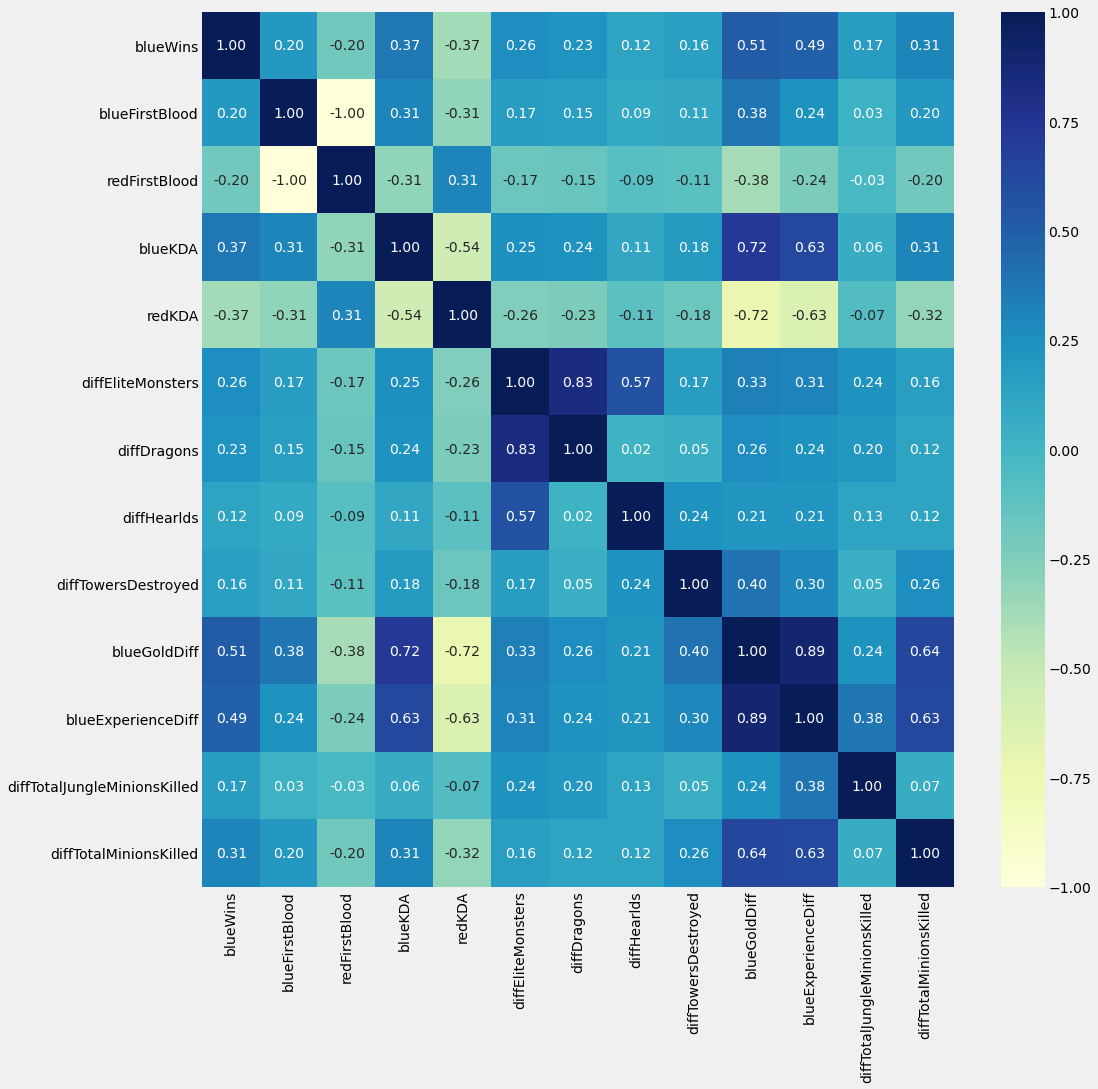

In [46]:
plt.figure(figsize = (15,15))
sns.heatmap(corr_matrix, annot = True, fmt=".2f", cmap="YlGnBu")

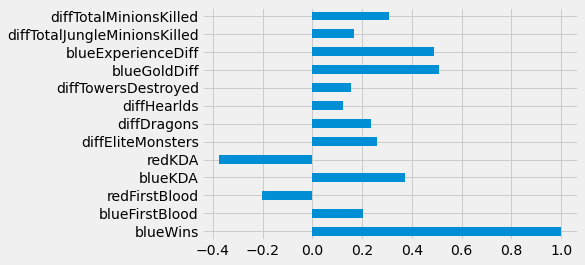

In [47]:
corr_matrix['blueWins'].plot(kind = 'barh')

### 训练

首先, 划分训练集和测试集 8:2

In [48]:
from sklearn.model_selection import train_test_split

X = data_final.drop(columns = ['blueWins'])
y = data_final['blueWins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

标准化

In [50]:
sc_cols = ['blueKDA', 'redKDA', 'blueGoldDiff', 'blueExperienceDiff', 'diffTotalJungleMinionsKilled', 'diffTotalMinionsKilled']

In [51]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train[sc_cols] = sc.fit_transform(X_train[sc_cols])
X_test[sc_cols] = sc.transform(X_test[sc_cols])

c:\users\64801\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\64801\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
c:\users\64801\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [52]:
X_train.head()

,blueFirstBlood,redFirstBlood,blueKDA,redKDA,diffEliteMonsters,diffDragons,diffHearlds,diffTowersDestroyed,blueGoldDiff,blueExperienceDiff,diffTotalJungleMinionsKilled,diffTotalMinionsKilled
8261,1,0,1.930767,-0.887033,1,1,0,0,1.030243,0.936307,1.805589,-0.324921
76,0,1,-0.770501,-0.025252,-2,-1,-1,0,-0.417918,-0.654257,-0.929402,-0.131094
2549,0,1,-0.062331,-0.278717,2,1,1,0,-0.211271,0.183019,-0.087866,-0.421835
7716,1,0,0.602035,-0.684261,2,1,1,0,1.274054,1.115239,-0.508634,1.710262
7076,0,1,-0.949701,1.520886,0,-1,1,-1,-1.565093,-0.459153,1.244565,-1.390970


看一下所有分类器的baseline

In [66]:
class EstimatorSelectionHelper:
    # 初始化, 加载模型以及提前设置的一些超参数
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
        self.best = {}
    # 对每个模型的每组超参数都进行交叉验证
    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.best[key] = {'score':gs.best_score_,'params':gs.best_params_}
            self.grid_searches[key] = gs    
    # 对结果进行统计
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]
    # 最优超参数.
    def best_params(self):
        return self.best

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

models = {
    'Logistic Regression' : LogisticRegression(),
    'Decision Tree' : DecisionTreeClassifier(),
    'AdaBoost' : AdaBoostClassifier(),
    'GradientBoost' : GradientBoostingClassifier(),
    'RandomForest' : RandomForestClassifier(),
    'ETC' : ExtraTreesClassifier(),
    'Bag' : BaggingClassifier(),
    'XGBoost' : XGBClassifier(),
    'SVC' : SVC(),
    'KNN' : KNeighborsClassifier(),
    'NB' : GaussianNB(),
    'QDA' : QuadraticDiscriminantAnalysis(),
    'NN' : MLPClassifier(),
}

params = {
    'Logistic Regression' : {},
    'Decision Tree' : {},
    'AdaBoost' : {},
    'GradientBoost' : {},
    'RandomForest' : {},
    'XGBoost' : {},
    'SVC' : {},
    'KNN' : {},
    'NB' : {},
    'ETC' : {},
    'Bag' : {},
    'QDA' : {},
    'NN' : {},
}


In [73]:
Helper = EstimatorSelectionHelper(models, params)
Helper.fit(X_train, y_train, cv=5)
Helper.score_summary(sort_by='mean_score')

Running GridSearchCV for Logistic Regression.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for Decision Tree.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running GridSearchCV for AdaBoost.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for GradientBoost.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for RandomForest.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for ETC.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for Bag.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for XGBoost.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    3.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for KNN.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for NB.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running GridSearchCV for QDA.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running GridSearchCV for NN.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Logistic Regression
Decision Tree
AdaBoost
GradientBoost
RandomForest
ETC
Bag
XGBoost
SVC
KNN
NB
QDA
NN


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   14.5s finished


,estimator,min_score,mean_score,max_score,std_score
0,Logistic Regression,0.706962,0.731241,0.752532,0.0146397
8,SVC,0.708861,0.729216,0.743671,0.0123264
2,AdaBoost,0.703797,0.725295,0.749367,0.0148439
3,GradientBoost,0.706329,0.724156,0.743038,0.0125586
10,NB,0.710759,0.722384,0.731183,0.00810008
12,NN,0.708412,0.71783,0.734177,0.00961925
4,RandomForest,0.694937,0.715803,0.726755,0.0117437
5,ETC,0.689437,0.706948,0.713472,0.00887587
7,XGBoost,0.685642,0.699481,0.71284,0.0110348
6,Bag,0.68038,0.693787,0.708228,0.00938215


逻辑回归的效果最好, 那么我们将逻辑回归单独拿出来进行超参数Finetine

In [101]:
lr = LogisticRegression()

params = {
    'C' : [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0],
    'penalty' : ['l1', 'l2'],
    'solver' : ['liblinear'],
}

In [102]:
gs = GridSearchCV(lr, params, cv = 5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [103]:
gs.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [104]:
lr.set_params(**gs.best_params_)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [106]:
lr.coef_

array([[ 7.65637250e-04, -3.00092090e-02,  0.00000000e+00,
        -4.32621588e-02,  9.47986852e-02,  1.93724502e-01,
         0.00000000e+00, -3.40111189e-02,  9.76748442e-01,
         4.56393089e-01,  0.00000000e+00, -3.02763413e-02]])

In [107]:
y_pred = lr.predict(X_test)

In [108]:
from sklearn.metrics import classification_report
cr = classification_report(y_true = y_test, y_pred = y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       960
           1       0.74      0.75      0.74      1016

    accuracy                           0.73      1976
   macro avg       0.73      0.73      0.73      1976
weighted avg       0.73      0.73      0.73      1976



In [109]:
X_train.columns

Index(['blueFirstBlood', 'redFirstBlood', 'blueKDA', 'redKDA',
       'diffEliteMonsters', 'diffDragons', 'diffHearlds',
       'diffTowersDestroyed', 'blueGoldDiff', 'blueExperienceDiff',
       'diffTotalJungleMinionsKilled', 'diffTotalMinionsKilled'],
      dtype='object')

In [110]:
model_importance = pd.DataFrame(columns = X_train.columns)

In [115]:
data_dict = {}
for key, val in zip(X_train.columns, lr.coef_[0]):
    data_dict[key] = val

In [116]:
data_dict

{'blueFirstBlood': 0.0007656372498119738,
 'redFirstBlood': -0.030009208995972328,
 'blueKDA': 0.0,
 'redKDA': -0.04326215883699783,
 'diffEliteMonsters': 0.09479868517975581,
 'diffDragons': 0.19372450189787052,
 'diffHearlds': 0.0,
 'diffTowersDestroyed': -0.03401111886079118,
 'blueGoldDiff': 0.9767484421609317,
 'blueExperienceDiff': 0.45639308927389816,
 'diffTotalJungleMinionsKilled': 0.0,
 'diffTotalMinionsKilled': -0.03027634134648423}